In [1]:
import pandas as pd

import Utils.PTModel.Training as Training
import Utils.Data.DataLoading as DataLoading
import Utils.EvaluationMetrics.TSNEVisual as TSNEVisual
import Utils.PTModel.Inference as Inference

In [2]:
# Loading standard train test split
TrainingData = DataLoading.LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)

tensor([1.8435, 4.9313, 1.5824, 2.1321, 6.8857, 4.0443, 5.1142, 5.3510, 6.4670,
        2.5497, 6.2026, 4.8471, 2.6795])


In [3]:
model = Training.TrainModel(TrainingData, 1, 32)

/home/surfytom/Projects/Dissertation/Repos/TileEmbeddingDissertation/srcTom/Utils/PTModel/Training.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)


Epoch 0: loss 6305.022319136462


In [4]:
Inference.SaveUnifiedRepresentation(model, pd.concat([TrainingData["trainData"], TrainingData["testData"]]), "../data/tomData/unifiedRep/TestModel")

Does not exists


In [31]:
data, fitEmbeddings = TSNEVisual.TrainTSNEModel("../data/tomData/unifiedRep")

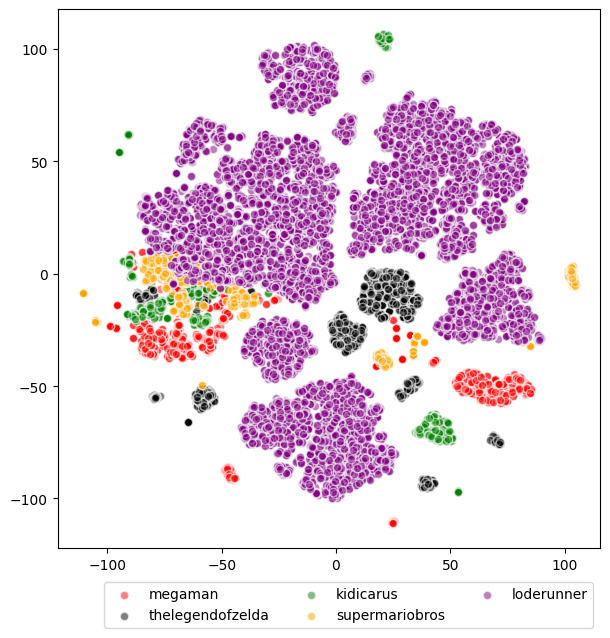

In [37]:
TSNEVisual.DisplayTSNEEmbeddings(data, fitEmbeddings)